In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-stress-prediction/Stress.csv


In [2]:
df = pd.read_csv("/kaggle/input/human-stress-prediction/Stress.csv")
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [3]:
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


((2838, 7), None)

In [4]:
not_used_cols = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df1 = df.drop(not_used_cols,axis=1)
df1.sample(3)

,text,label
996,Usually after each session I get a headache al...,1
212,I dial. 000. I have never used that number bef...,0
1259,"She then said to me ""Am I not worth the effort...",1


In [5]:
df1['label'].unique()

array([1, 0])

In [6]:
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
nltk.download('omw-1.4') # Open Multilingual Wordnet, this is an lexical database 
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [9]:
def textPocess(sent):
    try:
        # brackets replacing by space
        sent = re.sub('[][)(]',' ',sent)

        # url removing
        sent = [word for word in sent.split() if not urlparse(word).scheme]
        sent = ' '.join(sent)

        # removing escap characters
        sent = re.sub(r'\@\w+','',sent)

        # removing html tags 
        sent = re.sub(re.compile("<.*?>"),'',sent)

        # getting only characters and numbers from text
        sent = re.sub("[^A-Za-z0-9]",' ',sent)

        # lower case all words
        sent = sent.lower()
        
        # strip all words from sentences
        sent = [word.strip() for word in sent.split()]
        sent = ' '.join(sent)

        # word tokenization
        tokens = word_tokenize(sent)
        
        # removing words which are in stopwords
        for word in tokens:
            if word in stop_words:
                tokens.remove(word)
        
        # lemmatization
        sent = [lemmatizer.lemmatize(word) for word in tokens]
        sent = ' '.join(sent)
        return sent
    
    except Exception as ex:
        print(sent,"\n")
        print("Error ",ex)
    

In [10]:
df1['processed_text'] = df1['text'].apply(lambda text: textPocess(text))
df1.sample(3)

,text,label,processed_text
2542,-\tYou must own an iPhone or iPod touch (5th g...,0,must iphone ipod touch 5th generation order pa...
793,I was a little confused at what they meant so ...,0,little confused meant her husband decided meet...
2329,I have completely given up hobbies and interes...,1,have completely given hobby interest outside w...


In [11]:
print("without process ----> ",df1['text'].iloc[23],end='\n\n')
print("after process ----> ",df1['processed_text'].iloc[23])

without process ---->  With a switch blade and open arms In a sweater vest that covers a ragged undershirt stained with my innocence Through faces that are never the same as the ones I dread finding in the crowd In the night, I rediscover my love of mares and how hoarse I can be in the morning It's the taste of blood but I am not bleeding

after process ---->  switch blade open arm a sweater vest cover a ragged undershirt stained innocence face are never same one dread finding crowd the night rediscover my love mare how hoarse can in the morning s the taste blood i not bleeding


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
MIN_DF = 1 
# min_df is used for removing terms that appear too infrequently. 
# For example: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents". 

In [13]:
cv = CountVectorizer(min_df=MIN_DF)
cv_df = cv.fit_transform(df1['processed_text'])
cv_df.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
cv_df = pd.DataFrame(cv_df.toarray(),columns=cv.get_feature_names_out())
cv_df.head(3)

,00,000,00am,00pm,02,06,10,100,1000,100kg,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tf = TfidfVectorizer(min_df=MIN_DF)
tf_df = tf.fit_transform(df1['processed_text'])
tf_df.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
tf_df = pd.DataFrame(tf_df.toarray(),columns=tf.get_feature_names_out())
tf_df.head(3)

,00,000,00am,00pm,02,06,10,100,1000,100kg,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
tf_df.describe()

,00,000,00am,00pm,02,06,10,100,1000,100kg,...,zines,zinsser,zip,zofran,zoloft,zombie,zone,zoo,zuko,zumba
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,0.000455,0.000548,0.000123,0.000159,0.000109,0.000069,0.003359,0.001785,0.000576,0.000106,...,0.000078,0.000072,0.000205,0.000078,0.000715,0.000126,0.000245,0.000089,0.000054,0.000040
std,0.011202,0.009996,0.006576,0.006637,0.005808,0.003671,0.021364,0.017220,0.011161,0.005624,...,0.004163,0.003860,0.007802,0.004157,0.011803,0.004747,0.006854,0.004745,0.002886,0.002105
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.348402,0.327600,0.350306,0.333106,0.309398,0.195542,0.258662,0.267281,0.310333,0.299611,...,0.221775,0.205631,0.336077,0.221471,0.306537,0.184359,0.268149,0.252775,0.153731,0.112136


In [20]:
cv_df.shape,tf_df.shape

((2838, 10272), (2838, 10272))

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [22]:
X_train,X_test,y_train,y_test = train_test_split(cv_df,df1['label'],stratify=df1['label'])
X_train.shape,y_test.shape

((2128, 10272), (710,))

In [23]:
model_lr = LogisticRegression().fit(X_train,y_train)
model_lr.score(X_train,y_train),model_lr.score(X_test,y_test)

(0.9971804511278195, 0.7394366197183099)

In [24]:
model_nb = MultinomialNB().fit(X_train,y_train)
model_nb.score(X_train,y_train),model_nb.score(X_test,y_test)

(0.9295112781954887, 0.7323943661971831)

In [25]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(tf_df,df1['label'],stratify=df1['label'])
X_train1.shape,y_test1.shape

((2128, 10272), (710,))

In [26]:
model_lr = LogisticRegression().fit(X_train1,y_train1)
model_lr.score(X_train1,y_train1),model_lr.score(X_test1,y_test1)

(0.9088345864661654, 0.7309859154929578)

In [27]:
model_lr = LogisticRegression().fit(X_train1,y_train1)
model_lr.score(X_train1,y_train1),model_lr.score(X_test1,y_test1)

(0.9088345864661654, 0.7309859154929578)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [29]:
y_pred = model_lr.predict(X_test1)
cm = confusion_matrix(y_pred,y_test1)
cm

array([[247, 100],
       [ 91, 272]])

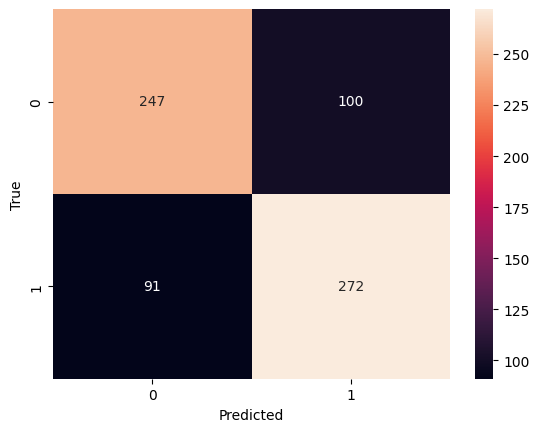

In [30]:
sns.heatmap(cm,annot=True,fmt='')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
print(classification_report(y_pred,y_test1))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       347
           1       0.73      0.75      0.74       363

    accuracy                           0.73       710
   macro avg       0.73      0.73      0.73       710
weighted avg       0.73      0.73      0.73       710



In [32]:
model = LogisticRegression().fit(tf_df,df1['label'])
model.score(tf_df,df1['label'])

0.8992248062015504

In [33]:
def predictor(text):
    processed = textPocess(text)
    embedded_words = tf.transform([text])
    res = model.predict(embedded_words)
    if res[0] == 1:
        res = "this person is in stress"
    else:
        res = "this person is not in stress"
    return res

In [34]:
text1 = """This is the worst thing that happened to me today. I got less marks in my exam, 
            so it is not going to help me in my future."""
text2 = """Hi Shashank sir, I gained a lot of knowledge from you for my future use. 
            This was a very fun journey for me. Thanks for boosting my confidence."""

text3 = """
User: Hi, I need help!

Chatbot: Of course, what can I assist you with?

User: I have a deadline tomorrow and I haven't even started on my project yet. I'm freaking out!

Chatbot: Okay, take a deep breath. Let's start by breaking down the project into smaller tasks. 
What do you need to do first?

User: I need to gather some research and data, but I don't even know where to start!

Chatbot: No problem. Let's begin by outlining the main points of your project, 

and then we can find the resources you need to complete each section. Can you tell me more about your project?

User: It's a marketing report for my boss. I need to analyze our competitors and come up with a new marketing strategy.

Chatbot: Great, that gives us a good starting point. 

Let's look for industry reports and market research that can give you insights into your competitors. 

And don't forget to take breaks and pace yourself as you work on each section. You got this!"""

text4 = """
User: Hi there! How are you doing today?

Chatbot: Hello! I'm doing well, thanks for asking. How about you?

User: I'm doing pretty well too, thanks. I just wanted to ask you a question about your service.

Chatbot: Of course, I'm here to help. What can I assist you with?

User: I'm interested in learning more about your pricing options. Can you provide me with some information?

Chatbot: Absolutely! We have several different pricing plans depending on your needs. 

Would you like me to send you a link to our pricing page?

User: Yes, that would be great. Also, do you offer any discounts or promotions?

Chatbot: Yes, we do offer discounts for long-term contracts and for certain types of organizations. 

Would you like me to provide more details?

User: That would be helpful, thank you.

Chatbot: Sure thing! Our team can provide you with all the information you need to make an informed decision. 

Is there anything else I can help you with today?"""

In [35]:
print(predictor(text1))
print(predictor(text2))
print(predictor(text3))
print(predictor(text4))

this person is in stress
this person is not in stress
this person is in stress
this person is not in stress
